# Unified Phytoplankton Pipeline (Preprocessing + Stacking Ensemble)

This notebook merges the previously saved preprocessing pipeline (`phytoplankton_preprocessing_pipeline.pkl`) and the stacking ensemble components (`mobilenetv2_regression.pth`, `resnet18_regression.pth`, and `phytoplankton_stacking_ensemble.pkl`) into a single serialized object: **`phytoplankton_full_pipeline.pkl`**.

## Contents
1. Load individual components
2. Define model architectures (must match training)
3. Build wrapper class for end-to-end inference
4. Merge & export unified pickle
5. Run inference on a sample image and display output

> Assumptions: Paths reflect the current repository layout on Windows. Adjust if your directory structure differs. The sample image is taken from `Pelgas Dataset/deep dataset/00001.jpg`. If your target images differ in resolution, preprocessing still normalizes them to 224x224 for the CNN models.

In [19]:
# Imports & Paths
import os, pickle, datetime, json
from PIL import Image
import numpy as np
import torch, torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.linear_model import RidgeCV

BASE_DIR = r'e:\SIH AI'
PELGA_DIR = os.path.join(BASE_DIR, 'Pelgas Dataset')
PREP_PKL_PATH = os.path.join(BASE_DIR, 'phytoplankton_preprocessing_pipeline.pkl')  # root copy
if not os.path.exists(PREP_PKL_PATH):
    # fallback inside Pelgas Dataset
    PREP_PKL_PATH = os.path.join(PELGA_DIR, 'phytoplankton_preprocessing_pipeline.pkl')
STACK_PKL_PATH = os.path.join(PELGA_DIR, 'phytoplankton_stacking_ensemble.pkl')
MOBILENET_WT = os.path.join(PELGA_DIR, 'mobilenetv2_regression.pth')
RESNET_WT = os.path.join(PELGA_DIR, 'resnet18_regression.pth')
LABELS_CSV = os.path.join(PELGA_DIR, 'deep large dataset', 'labels.csv')  # used to recover class names
MERGED_OUT = os.path.join(PELGA_DIR, 'phytoplankton_full_pipeline.pkl')
SAMPLE_IMAGE = os.path.join(PELGA_DIR, 'deep dataset', '00001.jpg')

print('Preprocessing pickle:', PREP_PKL_PATH)
print('Stacking ensemble pickle:', STACK_PKL_PATH)
print('MobileNet weights:', MOBILENET_WT)
print('ResNet18 weights:', RESNET_WT)
print('Labels CSV:', LABELS_CSV)
print('Sample image:', SAMPLE_IMAGE)

Preprocessing pickle: e:\SIH AI\phytoplankton_preprocessing_pipeline.pkl
Stacking ensemble pickle: e:\SIH AI\Pelgas Dataset\phytoplankton_stacking_ensemble.pkl
MobileNet weights: e:\SIH AI\Pelgas Dataset\mobilenetv2_regression.pth
ResNet18 weights: e:\SIH AI\Pelgas Dataset\resnet18_regression.pth
Labels CSV: e:\SIH AI\Pelgas Dataset\deep large dataset\labels.csv
Sample image: e:\SIH AI\Pelgas Dataset\deep dataset\00001.jpg


In [20]:
from phytoplankton_pipeline import (
    PhytoplanktonPreprocessingPipeline,
    MobileNetV2Reg,
    ResNet18Reg
)
import pickle, torch

with open(r'e:\\SIH AI\\phytoplankton_preprocessing_pipeline.pkl','rb') as f:
    prep = pickle.load(f)

with open(r'e:\\SIH AI\\Pelgas Dataset\\phytoplankton_stacking_ensemble.pkl','rb') as f:
    meta_learner = pickle.load(f)

In [21]:
# Recover class column names from labels.csv (used during training)
import pandas as pd
if os.path.exists(LABELS_CSV):
    labels_df = pd.read_csv(LABELS_CSV)
    class_columns = [c for c in labels_df.columns if c != 'filename']
else:
    # Fallback: infer from meta_learner.coef_ shape (must be divisible by number of base models)
    # This is a heuristic and may not preserve original ordering.
    total_outputs = meta_learner.coef_.shape[1] if len(meta_learner.coef_.shape) > 1 else meta_learner.coef_.shape[0]
    # Assume exactly 2 base models (MobileNetV2 + ResNet18)
    num_classes = total_outputs // 2
    class_columns = [f'class_{i}' for i in range(num_classes)]
print(f'Classes detected: {len(class_columns)}')

Classes detected: 127


In [22]:
# Define lightweight CNN architectures matching training phase
class MobileNetV2Reg(nn.Module):
    def __init__(self, num_outputs):
        super().__init__()
        self.base = torchvision.models.mobilenet_v2(weights=None)
        self.base.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.base.last_channel, num_outputs)
        )
    def forward(self, x):
        return self.base(x)

class ResNet18Reg(nn.Module):
    def __init__(self, num_outputs):
        super().__init__()
        self.base = torchvision.models.resnet18(weights=None)
        self.base.fc = nn.Linear(self.base.fc.in_features, num_outputs)
    def forward(self, x):
        return self.base(x)

In [23]:
# Instantiate models & load weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_outputs = len(class_columns)
mobilenet_model = MobileNetV2Reg(num_outputs)
resnet_model = ResNet18Reg(num_outputs)
mobilenet_model.load_state_dict(torch.load(MOBILENET_WT, map_location=device))
resnet_model.load_state_dict(torch.load(RESNET_WT, map_location=device))
mobilenet_model.to(device); resnet_model.to(device)
models = {'mobilenetv2': mobilenet_model, 'resnet18': resnet_model}
print('Models loaded onto', device)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_25088\1475118677.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mobilenet_model.load_state_dict(torch.load(MOBILENET_WT, ma

Models loaded onto cuda


In [29]:
# Define the unified wrapper class
class PhytoplanktonFullPipeline:
    def __init__(self, preprocessing_pipeline, models, meta_learner, class_columns, threshold=0.5, device=None):
        self.preprocessing_pipeline = preprocessing_pipeline
        self.models = models  # dict name->torch model
        self.meta_learner = meta_learner
        self.class_columns = class_columns
        self.threshold = threshold
        self.device = device or torch.device('cpu')
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def _prepare_image(self, img):
        if isinstance(img, str):
            img = Image.open(img).convert('RGB')
        processed_img, rois = self.preprocessing_pipeline.process(img)
        # Ensure processed_img is RGB
        if processed_img.mode != 'RGB':
            processed_img = processed_img.convert('RGB')
        tensor = self.transform(processed_img).unsqueeze(0).to(self.device)
        return tensor, rois, processed_img

    def predict(self, img):
        tensor, rois, processed_img = self._prepare_image(img)
        base_preds = []
        for name, model in self.models.items():
            model.eval()
            with torch.no_grad():
                out = model(tensor).cpu().numpy()  # shape (1, num_classes)
            base_preds.append(out)
        X_stack = np.hstack(base_preds)  # shape (1, num_classes * n_models)
        y_pred = self.meta_learner.predict(X_stack)[0]  # shape (num_classes,)
        counts = {cls: float(val) for cls, val in zip(self.class_columns, y_pred)}
        presence = {cls: int(val > self.threshold) for cls, val in zip(self.class_columns, y_pred)}
        summary = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:10]
        return {
            'counts': counts,
            'presence': presence,
            'rois': rois,
            'top10': summary,
            'processed_image': processed_img
        }

In [30]:
# Build unified object
full_pipeline = PhytoplanktonFullPipeline(
    preprocessing_pipeline=prep,
    models=models,
    meta_learner=meta_learner,
    class_columns=class_columns,
    threshold=0.5,
    device=device
)
print('Unified pipeline object ready.')

Unified pipeline object ready.


In [31]:
# Serialize merged pipeline (single pickle)
with open(MERGED_OUT, 'wb') as f:
    pickle.dump({
        'pipeline': full_pipeline,
        'build_meta': {
            'date': datetime.datetime.utcnow().isoformat() + 'Z',
            'device': str(device),
            'base_models': list(models.keys()),
            'num_classes': len(class_columns),
            'class_columns': class_columns
        }
    }, f)
print('Merged pipeline saved to:', MERGED_OUT)

Merged pipeline saved to: e:\SIH AI\Pelgas Dataset\phytoplankton_full_pipeline.pkl


Top 10 (class, predicted count):
artefact__85008: 2.853
Cnidaria_Metazoa__11512: 0.685
Neoceratium__18758: 0.596
egg unkn temp_Engraulidae temp__85345: 0.589
egg_Actinopterygii__85117: 0.523
part_Cnidaria__84970: 0.413
Noctiluca_Noctilucaceae__58408: 0.386
Euphausiacea__45041: 0.262
Peltidiidae__93861: 0.206
part_Siphonophorae__92039: 0.204

Number of detected ROIs (preprocessing heuristic): 3


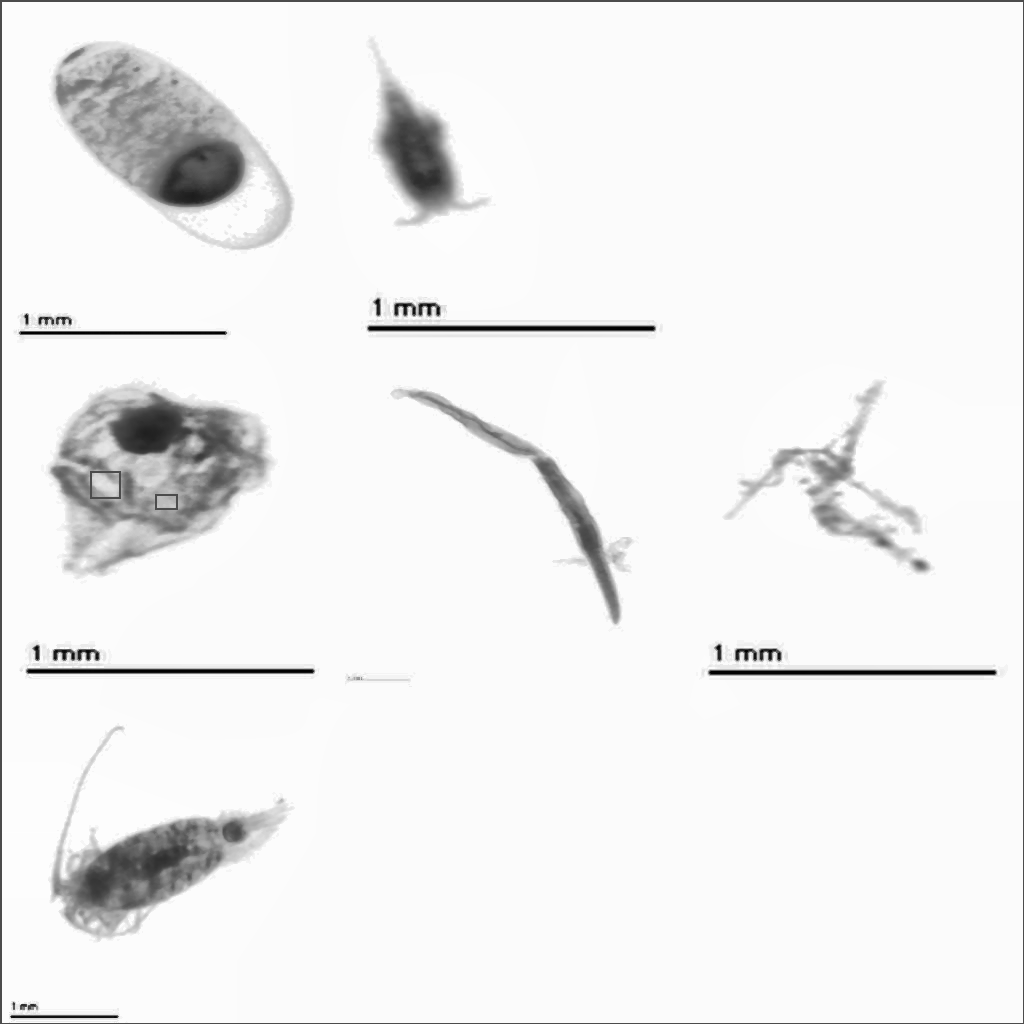

In [32]:
# Inference Demo on a Sample Image
if not os.path.exists(SAMPLE_IMAGE):
    raise FileNotFoundError('Sample image not found at ' + SAMPLE_IMAGE)
result = full_pipeline.predict(SAMPLE_IMAGE)
print('Top 10 (class, predicted count):')
for cls, val in result['top10']:
    print(f'{cls}: {val:.3f}')
print('\nNumber of detected ROIs (preprocessing heuristic):', len(result['rois']))
# Show processed image (with ROI marks) if running in an environment that supports display
result['processed_image']

## Loading the Merged Pickle Elsewhere
```python
import pickle, torch
with open(r'e:/SIH AI/Pelgas Dataset/phytoplankton_full_pipeline.pkl', 'rb') as f:
    payload = pickle.load(f)
full_pipeline = payload['pipeline']
result = full_pipeline.predict('path_to_new_image.jpg')
print(result['top10'])
```

> Note: Because Python pickle stores object structure (not code), make sure the class definitions (`PhytoplanktonFullPipeline`, `MobileNetV2Reg`, `ResNet18Reg`, and the preprocessing pipeline class) are available in the Python session when unpickling in a different script or environment. A simple way is to copy the relevant class code into a module (e.g., `phytoplankton_pipeline.py`) and import it before loading the pickle.